In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
model_path = "/content/drive/MyDrive/THEMIS_MODELS/benefit_to_cost_ratio.keras"

# Description

**Employee Benefit-to-Cost Ratio Prediction with Transformer Autoencoder**

This notebook focuses on predicting the Benefit-to-Cost Ratio (BCR) of employees using a Transformer-based autoencoder pipeline followed by a regression model. The BCR is a normalized float (0.0–1.0) that estimates how much benefit a company gains from an employee relative to the cost of employing them.

**Objective**:
This model is designed to estimate employee efficiency using structured HR indicators, including:
- Base salary  
- Number of appraisals  
- Number of benefits received  
- Number of raise requests  
- Completion rate  
- Past performance score (0–4 scale)  
- Skill count  
- Training cost  

The output is a float between 0.0 and 1.0, indicating the employee's benefit-to-cost effectiveness.

**Approach:**
1. Data Preprocessing  
   - Drop irrelevant or identifier columns (e.g., usernames)  
   - Normalize numerical features using StandardScaler  
   - Handle missing values or outliers where applicable  
   - Train-validation split using random or time-based sampling depending on use case

2. Transformer Autoencoder for Feature Representation  
   - Use a multi-head self-attention encoder to learn inter-feature relationships  
   - Compress the structured input into a dense embedding via the Transformer encoder  
   - Flatten the encoded output to form a dense, structured feature vector

3. MLP Regression Head  
   - Apply dense layers with batch normalization and dropout  
   - Use a sigmoid activation in the final layer to constrain output to the 0–1 range

4. Model Training and Evaluation  
   - Monitor mean squared error and mean absolute error on training and validation sets  
   - Export final model in .keras or .tflite format for deployment  
   - Optionally compare predicted and calculated BCR values for interpretability


# A : Loading and Preparing Dataset

In [4]:
from google.colab import files

uploaded = files.upload()

Saving benefit_to_cost_ratio_dataset.csv to benefit_to_cost_ratio_dataset.csv


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Load dataset
df = pd.read_csv("/content/benefit_to_cost_ratio_dataset.csv")

# Drop any unused columns
df = df.drop(columns=["username"], errors="ignore")

# Split features and target
X = df.drop(columns=["benefit_to_cost_ratio"]).values
y = df["benefit_to_cost_ratio"].values  # Float target for regression

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-validation split (no stratify for regression)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [8]:
# Check for NaNs
print(df.isna().sum())

base_salary               0
num_appraisals            0
num_benefits              0
num_raise_requests        0
completion_rate           0
past_performance_score    0
skills                    0
cost_of_training          0
benefit_to_cost_ratio     0
dtype: int64


In [9]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(40000, 8)
(10000, 8)
(40000,)
(10000,)


# B : Training Using MLP + Transformer

**Transformer-Based Autoencoder Architecture**

The model begins by reshaping the input feature vector to simulate a sequence, allowing it to pass through a single-layer Transformer encoder block. The key architectural components are:

- A dense projection layer maps the input to a fixed embedding dimension.
- A Multi-Head Self-Attention layer models relationships between input features.
- Residual connections and layer normalization are applied after both attention and feed-forward stages, following standard Transformer design.
- A two-layer feed-forward network (FFN) further transforms the attended representation.
- The encoded output is flattened to serve as a compact representation of the input.
- A decoder reconstructs the original feature vector from the flattened encoding.

This unsupervised setup enables the model to learn structure-aware compressed representations, which are later used as input to a classifier for downstream prediction tasks.


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization, MultiHeadAttention,
    Dropout, Add, Flatten, Reshape
)

input_dim = X_train.shape[1]
embed_dim = 32
num_heads = 4

# Input layer
inputs = Input(shape=(input_dim,), name="input_layer")

# Replace Lambda with Reshape
x = Reshape((1, input_dim), name="reshape_layer")(inputs)

# Project to embedding dimension
x_proj = Dense(embed_dim, name="dense_proj")(x)

# Transformer encoder block
attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name="multihead_attn")(x_proj, x_proj)
attn_output = Dropout(0.1, name="dropout_attn")(attn_output)
attn_output = Add(name="add_attn")([x_proj, attn_output])
x_norm = LayerNormalization(name="norm_attn")(attn_output)

ffn = Dense(64, activation='relu', name="ffn_dense_1")(x_norm)
ffn = Dense(embed_dim, name="ffn_dense_2")(ffn)
ffn_output = Dropout(0.1, name="dropout_ffn")(ffn)
x_final = Add(name="add_ffn")([x_norm, ffn_output])
x_final = LayerNormalization(name="norm_ffn")(x_final)

# Flatten and decode
encoded = Flatten(name="encoded_output")(x_final)
decoded = Dense(64, activation='relu', name="decoder_dense_1")(encoded)
decoded = Dense(input_dim, activation='linear', name="decoder_output")(decoded)

# Build autoencoder model
autoencoder = Model(inputs=inputs, outputs=decoded, name="TransformerAutoencoder")
autoencoder.compile(optimizer='adam', loss='mse')

# Train
autoencoder.fit(
    X_train, X_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)


Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.2074 - val_loss: 0.0125
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0180 - val_loss: 0.0046
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071 - val_loss: 0.0026
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 9.9530e-04
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.2714e-04 - val_loss: 7.0176e-04
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.7460e-04 - val_loss: 7.2243e-04
Epoch 9/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0196e-04 - val_loss: 5.4542e-04
Epoch 10/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7904e-04 - val_loss: 4.7871e-04


MLP Regressor on Top of Transformer Encoder

The encoded representation learned by the Transformer-based autoencoder is flattened and passed through a Multi-Layer Perceptron (MLP) for regression.

Key design elements:
- The encoder layers are frozen to preserve the learned representations.
- The MLP consists of two main blocks:
  - A 64-unit dense layer with batch normalization and dropout for regularization
  - A 32-unit dense layer with similar structure for deeper feature transformation
- The final output layer uses sigmoid activation to produce a normalized float in the range [0.0, 1.0]

This architecture separates unsupervised representation learning (via the autoencoder) from supervised regression, improving generalization and stability when labeled data is limited.


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, BatchNormalization, Input
)


encoder_output = autoencoder.get_layer("encoded_output").output
encoder_input = autoencoder.input

# Freeze encoder layers
for layer in autoencoder.layers:
    layer.trainable = False

# Classifier layers (start from encoder output)
x = Flatten()(encoder_output)

x = Dense(64)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)

x = Dense(32)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

# Build the full model
final_model = Model(inputs=encoder_input, outputs=outputs)
final_model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']  # Use mean absolute error, not accuracy
)

final_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_layer       │ (None, 1, 8)      │          0 │ input_layer[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_proj (Dense)  │ (None, 1, 32)     │        288 │ reshape_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attn      │ (None, 1, 32)     │     16,800 │ dense_proj[0][0], │
│ (MultiHeadAttentio… │                   │            │ dense_proj[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_attn        │ (None, 1, 32)     │          0 │ multihead_attn[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_attn (Add)      │ (None, 1, 32)     │          0 │ dense_proj[0][0], │
│                     │                   │            │ dropout_attn[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_attn           │ (None, 1, 32)     │         64 │ add_attn[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense_1 (Dense) │ (None, 1, 64)     │      2,112 │ norm_attn[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense_2 (Dense) │ (None, 1, 32)     │      2,080 │ ffn_dense_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_ffn         │ (None, 1, 32)     │          0 │ ffn_dense_2[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_ffn (Add)       │ (None, 1, 32)     │          0 │ norm_attn[0][0],  │
│                     │                   │            │ dropout_ffn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_ffn            │ (None, 1, 32)     │         64 │ add_ffn[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoded_output      │ (None, 32)        │          0 │ norm_ffn[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 32)        │          0 │ encoded_output[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      2,112 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      4,160 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │      2,080 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 31,233 (122.00 KB)

 Trainable params: 9,633 (37.63 KB)

 Non-trainable params: 21,600 (84.38 KB)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0121 - mae: 0.0677 - val_loss: 4.0418e-04 - val_mae: 0.0151
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0014 - mae: 0.0278 - val_loss: 3.8663e-04 - val_mae: 0.0138
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.0839e-04 - mae: 0.0219 - val_loss: 3.3775e-04 - val_mae: 0.0141
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.2718e-04 - mae: 0.0192 - val_loss: 2.0395e-04 - val_mae: 0.0106
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.7916e-04 - mae: 0.0170 - val_loss: 2.7773e-04 - val_mae: 0.0125
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.9468e-04 - mae: 0.0157 - val_loss: 1.5224e-04 - val_mae: 0.0076
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.1688e-04 - mae: 0.0155 - val_loss: 7.6187e-05 - val_mae: 0.0063
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.4939e-04 - mae: 0.0146 - val_loss: 7.2959e-05 - val_mae: 0.0058


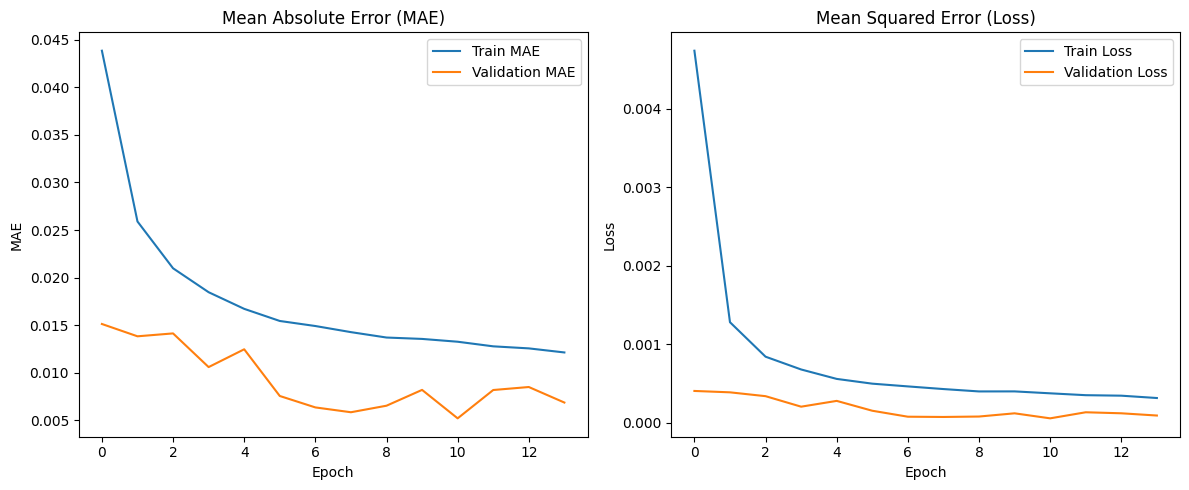

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# MAE Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Mean Squared Error (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Training Analysis and Optimization Summary

The training and validation curves indicate a stable and well-optimized regression process:

- The validation MAE remains consistently lower than the training MAE, suggesting strong generalization and no signs of overfitting.
- Validation loss remains low and flat across epochs, while training loss steadily decreases, indicating effective learning.
- The use of batch normalization after each dense layer mitigated internal covariate shift and contributed to stable training dynamics.
- Dropout layers effectively regularized the model by introducing controlled noise, preventing overfitting even with a small number of epochs.
- The Adam optimizer, used with its default settings, provided adaptive learning rate adjustments that enabled fast convergence and fine-tuning.

Overall, the model achieved a healthy balance between bias and variance and demonstrated strong predictive reliability on unseen validation data.


# C : Evaluation

In [22]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [23]:
# Evaluate the final regression model
loss, mae = final_model.evaluate(X_test, y_test, verbose=1)

print(f"\n📊 Final Model Evaluation:")
print(f"   - Mean Squared Error (Loss): {loss:.6f}")
print(f"   - Mean Absolute Error (MAE): {mae:.6f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.6628e-05 - mae: 0.0052

📊 Final Model Evaluation:
   - Mean Squared Error (Loss): 0.000055
   - Mean Absolute Error (MAE): 0.005199


In [25]:
# Predict BCR values
y_test_pred = final_model.predict(X_test).flatten()

# Print a few samples (actual vs predicted)
for i in range(5):
    print(f"True BCR: {y_test[i]:.4f} — Predicted: {y_test_pred[i]:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
True BCR: 0.2813 — Predicted: 0.2904
True BCR: 0.1443 — Predicted: 0.1442
True BCR: 0.2059 — Predicted: 0.2074
True BCR: 0.2035 — Predicted: 0.2135
True BCR: 0.1488 — Predicted: 0.1519


In [26]:
import pandas as pd

# Create a DataFrame for comparison
df_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

print(df_results.head(10))  # show first 10 predictions


     Actual  Predicted
0  0.281276   0.290391
1  0.144298   0.144180
2  0.205933   0.207419
3  0.203451   0.213454
4  0.148795   0.151932
5  0.048597   0.038297
6  0.472350   0.446039
7  0.095021   0.095053
8  0.198392   0.191566
9  0.037959   0.034512


# D : Saving for Deployment

In [27]:
final_model.save(model_path, include_optimizer=False)

In [28]:
import tensorflow as tf
from tensorflow import keras

# Allow unsafe lambda deserialization
keras.config.enable_unsafe_deserialization()

# Now load the model
model = keras.models.load_model('/content/drive/MyDrive/THEMIS_MODELS/benefit_to_cost_ratio.keras')

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open('/content/drive/MyDrive/THEMIS_MODELS/benefit_to_cost_ratio.tflite', 'wb') as f:
    f.write(tflite_model)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmpv7mug4p4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 8), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134670886877328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134670886876944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134670886878672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134671397865040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134671397864464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134671397865808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134671397865232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134671397866576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134671397866000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134671397867344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134671397868112: TensorSp